# IMPORT DATASET

In [62]:
from statistics import median

import pandas as pd
import numpy as np
from numpy.random import logistic

titanic = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Data visualization

We'll view the dataset

In [38]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [39]:
titanic.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [40]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >, <Axes: >]],
      dtype=object)

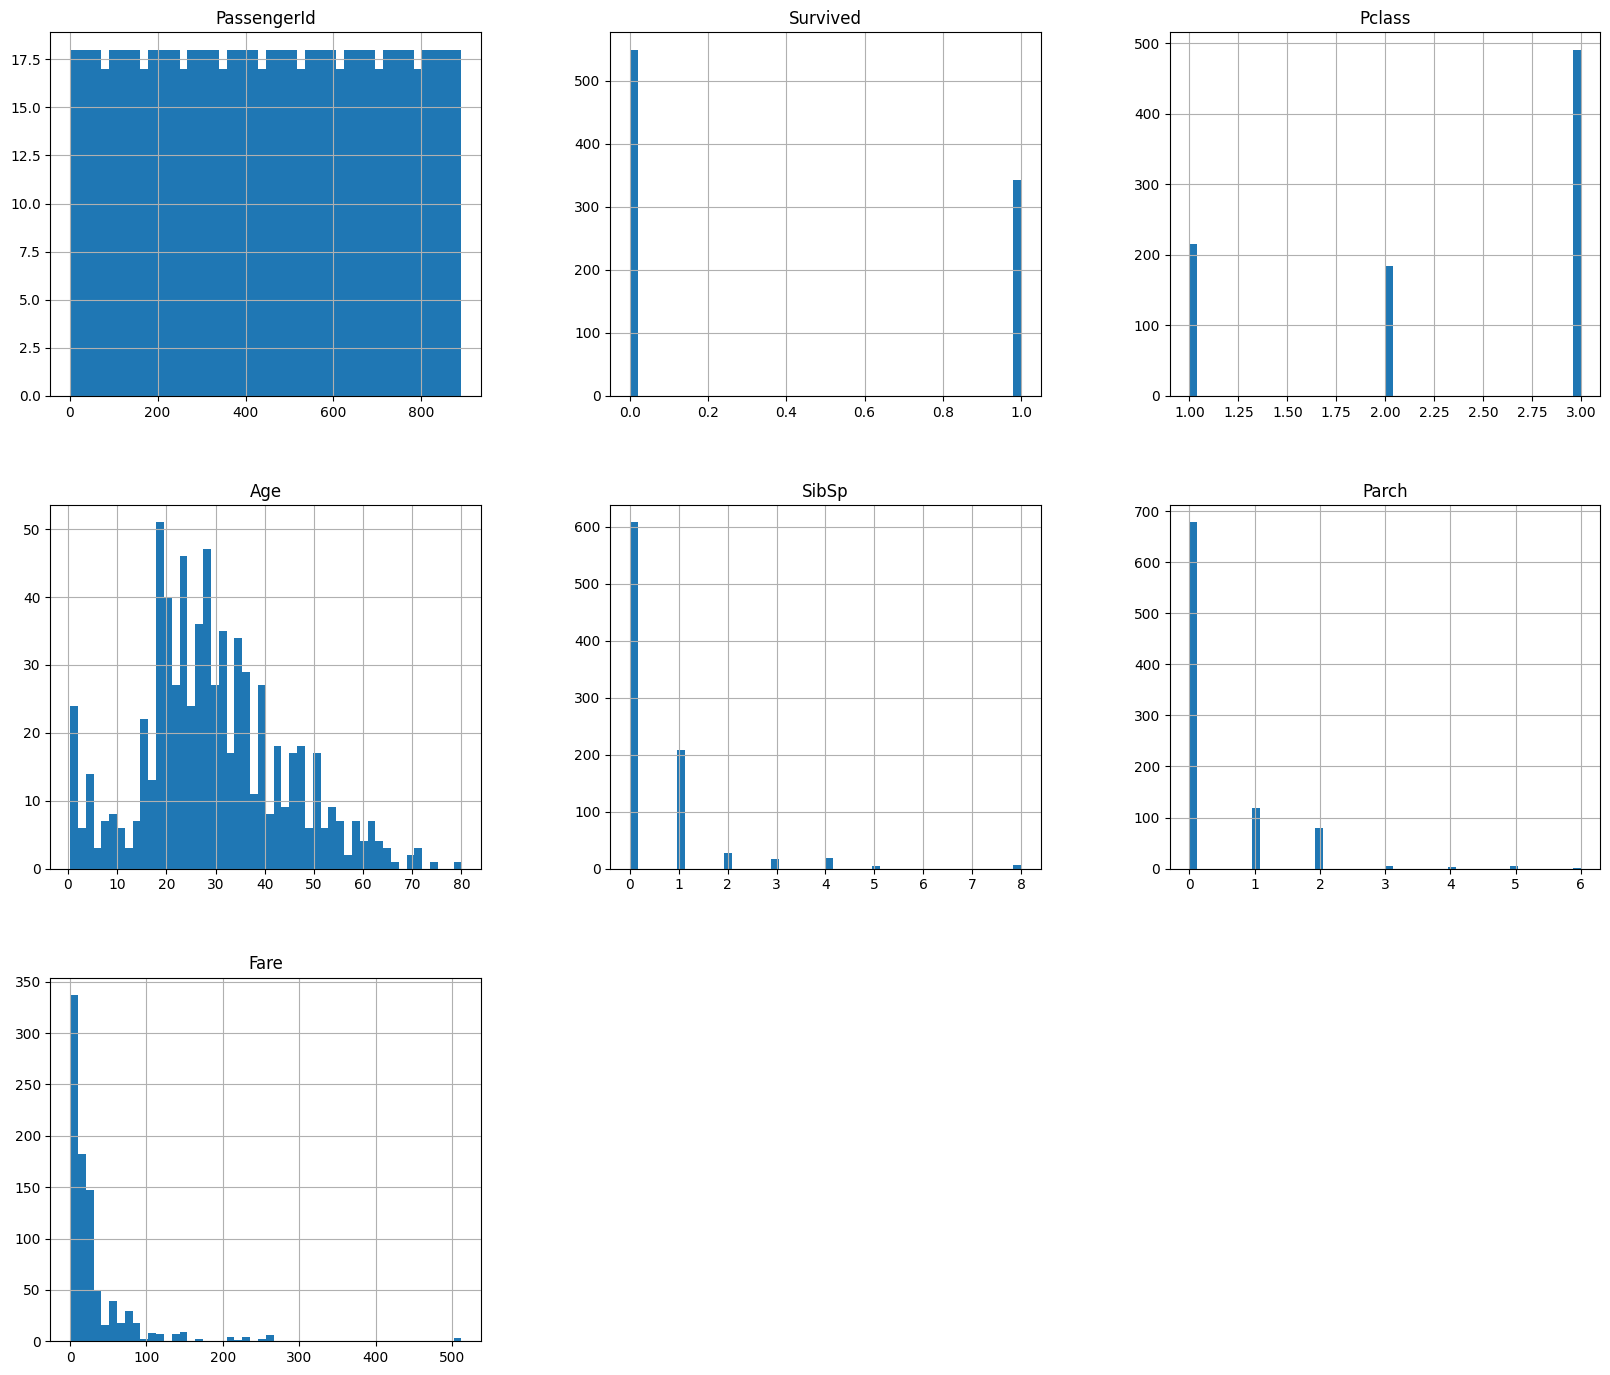

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
titanic.hist(bins = 50, figsize = (20, 17))

## Extract Passenger ID and Ticket, Survived (Target variable)

In [42]:
train_extracted = titanic.drop('PassengerId', axis = 1)
train_extracted = train_extracted.drop('Ticket', axis = 1)
train_extracted = train_extracted.drop('Survived', axis = 1)

train_labels = titanic['Survived']

In [43]:
train_extracted.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin',
       'Embarked'],
      dtype='object')

We'll transform the Name into a more modified form:

In [15]:
import re

def parse_name(name):
    # Split at the first comma: Last Name vs. the rest
    parts = name.split(',', 1)
    last_name = parts[0].strip()
    rest = parts[1].strip()

    # Regex breakdown:
    #   (\w+\.|\w+\s+\w+\.) → title: e.g., Mr., Don., Countess. (or compound like "Lady Duff.")
    #   ([^"(]+)             → first/middle name (up to parentheses or quotes)
    #   (["“”][^"]+["“”])?   → optional nickname in quotes (e.g., "Nellie")
    #   \(([^)]+)\)?         → optional alternate name in parentheses
    match = re.match(r'([\w]+\.)(\s+[^"(]+)?\s*(["“”][^"]+["“”])?\s*(\(([^)]+)\))?', rest)

    if match:
        title = match.group(1).strip()
        first_names = (match.group(2) or '').strip()
        nickname = (match.group(3) or '').strip('"“”') if match.group(3) else None
        alt_name = match.group(5) if match.group(5) else None

        return pd.Series({
            'last_name': last_name,
            'title': title,
            'first_names': first_names,
            'nickname': nickname,
            'alternate_name': alt_name
        })
    else:
        return pd.Series({
            'last_name': last_name,
            'title': None,
            'first_names': None,
            'nickname': None,
            'alternate_name': None
        })

In [18]:
parsed = train_extracted["Name"].apply(parse_name)
train_extracted = pd.concat([train_extracted, parsed], axis=1)

In [19]:
train_extracted = train_extracted.drop("Name", axis = 1)

Modify the PClass using OrdinalEncoder:

In [20]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
train_extracted["Pclass_encoded"] = ordinal_encoder.fit_transform(train_extracted[["Pclass"]])

In [21]:
train_extracted = train_extracted.drop('Pclass', axis = 1)

Investigate and encoded the Sex variable:

In [24]:
train_extracted['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [25]:
train_extracted["Sex_encoded"] = train_extracted["Sex"].map({"male": 0, "female": 1})

In [26]:
train_extracted = train_extracted.drop("Sex", axis = 1)

Dealing with Age variable:

1) Investigate to see if how many missing values here, if less than 5% => Delete
2) If not, proceed to add using the median age value

In [31]:
sum(train_extracted["Age"].value_counts()) / len(train_extracted["Age"])

0.8013468013468014

Nearly 20% have missing age. It's better to fill it up with something. Since I don't know what strategy is the best, I will proceed with Grid Search.

In [32]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy= 'median')
#Here just a code to remind myself

For number of sibling (SibSp) and number of parents (Parch), we can combine them to create a new variable call Family_size.

In [33]:
train_extracted['family_size'] = train_extracted['SibSp'] + train_extracted['Parch'] + 1

# Optional: Categorize family size
def family_group(size):
    if size == 1:
        return 'solo'
    elif size <= 4:
        return 'small'
    else:
        return 'large'

train_extracted['family_group'] = train_extracted['family_size'].apply(family_group)

Ok, now let's deal with fare. I think it's best to leave it as it is.

Ok, let's now turn to cabin. I think it's good to classify it into a binary variable: Has cabin or not.

In [35]:
train_extracted['Has_Cabin'] = train_extracted['Cabin'].notnull().astype(int)

In [36]:
train_extracted = train_extracted.drop('Cabin', axis = 1)

The last variable we need to deal with is the Embarked port. We shall use OneHotEncoder here.

# FULL PIPELINE CODE

Now that we're ready know what to do with each variable, we write the full pipeline processing:

In [ ]:
num_attributes = ['Age', 'SibSp', 'Parch', 'Fare']
cat_attributes = ['Pclass', 'Name', 'Sex', "Cabin", "Embarked"]

In [45]:
from sklearn.base import  BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes_names):
        self.attributes_name = attributes_names
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        return X[self.attributes_name].values

In [121]:
import pandas as pd
import numpy as np
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes_names):
        self.attributes_name = attributes_names
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        return X[self.attributes_name].values

class NameParser(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()

        parsed = X_transformed["Name"].apply(self._parse_name)
        X_transformed = pd.concat([X_transformed, parsed], axis=1)
        X_transformed = X_transformed.drop("Name", axis=1)

        return X_transformed

    def _parse_name(self, name):
        parts = name.split(',', 1)
        last_name = parts[0].strip()
        rest = parts[1].strip() if len(parts) > 1 else ""

        # Fixed regex pattern - replaced $$ with $$ and $$
        match = re.match(r'([\w]+\.)(\s+[^"(]+)?\s*(["""][^"]+["""])?\s*($$([^)]+)$$)?', rest)

        if match:
            title = match.group(1).strip()
            first_names = (match.group(2) or '').strip()
            nickname = (match.group(3) or '').strip('"""') if match.group(3) else None
            alt_name = match.group(5) if match.group(5) else None

            return pd.Series({
                'last_name': last_name,
                'title': title,
                'first_names': first_names,
                'nickname': nickname,
                'alternate_name': alt_name
            })
        else:
            return pd.Series({
                'last_name': last_name,
                'title': None,
                'first_names': None,
                'nickname': None,
                'alternate_name': None
            })

class FamilyFeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_family_group=True):
        self.add_family_group = add_family_group

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()

        X_transformed['family_size'] = X_transformed['SibSp'] + X_transformed['Parch'] + 1

        if self.add_family_group:
            X_transformed['family_group'] = X_transformed['family_size'].apply(self._family_group)

        return X_transformed

    def _family_group(self, size):
        if size == 1:
            return 'solo'
        elif size <= 4:
            return 'small'
        else:
            return 'large'

class CabinTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        X_transformed['Has_Cabin'] = X_transformed['Cabin'].notnull().astype(int)
        X_transformed = X_transformed.drop('Cabin', axis=1)
        return X_transformed

class SexEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        X_transformed["Sex_encoded"] = X_transformed["Sex"].map({"male": 0, "female": 1})
        X_transformed = X_transformed.drop("Sex", axis=1)
        return X_transformed

class PclassEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.encoder = OrdinalEncoder()
        self.encoder.fit(X[['Pclass']])
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        X_transformed["Pclass_encoded"] = self.encoder.transform(X_transformed[['Pclass']])
        X_transformed = X_transformed.drop("Pclass", axis=1)
        return X_transformed

# Modified approach: Split the pipeline into two parts
def process_titanic_data(train_data, test_data):
    print("Step 1: Applying initial transformations")
    # Initial transformations pipeline
    initial_pipeline = Pipeline([
        ('name_parser', NameParser()),
        ('family_features', FamilyFeatureAdder(add_family_group=True)),
        ('cabin_transformer', CabinTransformer()),
        ('sex_encoder', SexEncoder()),
        ('pclass_encoder', PclassEncoder())
    ])

    # Apply initial transformations
    initial_pipeline.fit(train_data)  # Fit once
    train_data_initial = initial_pipeline.transform(train_data)
    test_data_initial = initial_pipeline.transform(test_data)

    print("Finish initial pipeline code!")
    print("Step 2: Checking available features after initial transformations")
    print(f"Available features: {train_data_initial.columns.tolist()}")

    # Define features for the second pipeline
    num_features = ['Age', 'Fare', 'family_size', 'Pclass_encoded', 'Sex_encoded', 'Has_Cabin']
    cat_features = ['Embarked', 'family_group', 'title']

    # Verify all features exist
    missing_num = [f for f in num_features if f not in train_data_initial.columns]
    missing_cat = [f for f in cat_features if f not in train_data_initial.columns]

    # if missing_num or missing_cat:
    #     print(f"Warning: Missing numerical features: {missing_num}")
    #     print(f"Warning: Missing categorical features: {missing_cat}")
    #     # Use only available features
    #     num_features = [f for f in num_features if f in train_data_initial.columns]
    #     cat_features = [f for f in cat_features if f in train_data_initial.columns]
    #     print(f"Using available numerical features: {num_features}")
    #     print(f"Using available categorical features: {cat_features}")
    # DM e code xong roi moi ktra lai lol

    print("Step 3: Creating and applying final preprocessing")
    # Numerical pipeline
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('std_scaler', StandardScaler())
    ])

    # Categorical pipeline
    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('one_hot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine numerical and categorical pipelines
    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ])

    # Apply final preprocessing
    train_data_final = preprocessor.fit_transform(train_data_initial)
    test_data_final = preprocessor.transform(test_data_initial)

    return train_data_final, test_data_final

# SPLIT TRAIN SET AND TEST SET

We'll process them and train some model here.

In [122]:
# Load the data
print("Loading data...")
titanic = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

def remove(dataset, survive_remove=True):
    extracted = dataset.drop('PassengerId', axis=1)
    extracted = extracted.drop('Ticket', axis=1)
    if survive_remove:
        extracted = extracted.drop('Survived', axis=1)
    return extracted

print("Preparing data...")
train_data = remove(titanic, survive_remove=True)
test_data = remove(test, survive_remove=False)
train_labels = titanic['Survived'].copy()

# Process the data using our modified approach
train_data_prepared, test_data_prepared= process_titanic_data(train_data, test_data)

print(f"Training data prepared shape: {train_data_prepared.shape}")
print(f"Test data prepared shape: {test_data_prepared.shape}")

print("Successfully!")

Loading data...
Preparing data...
Step 1: Applying initial transformations...
Finish initial pipeline code!
Step 2: Checking available features after initial transformations...
Available features: ['Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'last_name', 'title', 'first_names', 'nickname', 'alternate_name', 'family_size', 'family_group', 'Has_Cabin', 'Sex_encoded', 'Pclass_encoded']
Step 3: Creating and applying final preprocessing...
Training data prepared shape: (891, 29)
Test data prepared shape: (418, 29)
Successfully!


C:\Users\Nhat Minh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\Nhat Minh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


# TRAIN MODEL

In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

print("Training a Logistic model")
lin_model = LogisticRegression(random_state=42, n_jobs=-1)
lin_model.fit(train_data_prepared, train_labels)

# Make predictions on training data to check performance
train_preds = lin_model.predict(train_data_prepared)
train_accuracy = accuracy_score(train_labels, train_preds)
print(f"Training accuracy: {train_accuracy:.4f}")

Training a Logistic model
Training accuracy: 0.8373


In [134]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

print("Training a Random Forest model")
ranfor_model = RandomForestClassifier(n_estimators=100, random_state=42)
ranfor_model.fit(train_data_prepared, train_labels)

# Make predictions on training data to check performance
train_preds = ranfor_model.predict(train_data_prepared)
train_accuracy = accuracy_score(train_labels, train_preds)
print(f"Training accuracy: {train_accuracy:.4f}")

Training a Random Forest model
Training accuracy: 0.9843


In [135]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

print('Training a Decision Tree Classifier')
decision_model = DecisionTreeClassifier(random_state=42)
decision_model.fit(train_data_prepared, train_labels)

#Make predictions
train_preds = decision_model.predict(train_data_prepared)
train_accuracy = accuracy_score(train_labels, train_preds)
print(f"Training accuracy: {train_accuracy: .4f}")

Training a Decision Tree Classifier
Training accuracy:  0.9843


Maybe DecisionTree and RandomForest are overfitting this. Let's try another

In [138]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

print('Training a KNN Classifier')
knn_model = KNeighborsClassifier()
knn_model.fit(train_data_prepared, train_labels)

#Make predictions
train_preds = knn_model.predict(train_data_prepared)
train_accuracy = accuracy_score(train_labels, train_preds)
print(f"Training accuracy: {train_accuracy: .4f}")

Training a KNN Classifier
Training accuracy:  0.8676


In [139]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

print('Training a GradientBoostingClassifier Classifier')
grad_model = GradientBoostingClassifier()
grad_model.fit(train_data_prepared, train_labels)

#Make predictions
train_preds = grad_model.predict(train_data_prepared)
train_accuracy = accuracy_score(train_labels, train_preds)
print(f"Training accuracy: {train_accuracy: .4f}")

Training a GradientBoostingClassifier Classifier
Training accuracy:  0.9001


Hmm, it seems like the best choice are GradientBoosingClassifier and KNN. Let's fine tune our models.

But I still want to use cross-validation to test out. Let's see.

In [132]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores", scores)
    print("Mean", scores.mean())
    print("Standard Deviation", scores.std())

Linear accuracy:

In [148]:
scores = cross_val_score(lin_model, train_data_prepared, train_labels, scoring= 'accuracy', cv=10)

display_scores(scores)

Scores [0.82222222 0.86516854 0.76404494 0.87640449 0.80898876 0.79775281
 0.83146067 0.80898876 0.86516854 0.87640449]
Mean 0.8316604244694134
Standard Deviation 0.03617783665838465


Random Forest accuracy:

In [149]:
scores = cross_val_score(ranfor_model, train_data_prepared, train_labels, scoring= 'accuracy', cv=10)

display_scores(scores)

Scores [0.77777778 0.88764045 0.73033708 0.82022472 0.83146067 0.84269663
 0.78651685 0.71910112 0.86516854 0.82022472]
Mean 0.8081148564294631
Standard Deviation 0.05193583140723809


Decision Tree accuracy:

In [151]:
scores = cross_val_score(decision_model, train_data_prepared, train_labels, scoring= 'accuracy', cv=10)

display_scores(scores)

Scores [0.72222222 0.80898876 0.6741573  0.79775281 0.78651685 0.82022472
 0.83146067 0.73033708 0.82022472 0.78651685]
Mean 0.777840199750312
Standard Deviation 0.04907689160572454


KNN accuracy:

In [152]:
scores = cross_val_score(knn_model, train_data_prepared, train_labels, scoring= 'accuracy', cv=10)

display_scores(scores)

Scores [0.8        0.85393258 0.76404494 0.83146067 0.87640449 0.85393258
 0.83146067 0.83146067 0.86516854 0.83146067]
Mean 0.833932584269663
Standard Deviation 0.031047853320456956


Gradient Boosting accuracy:

In [153]:
scores = cross_val_score(grad_model, train_data_prepared, train_labels, scoring= 'accuracy', cv=10)

display_scores(scores)

Scores [0.82222222 0.85393258 0.75280899 0.84269663 0.91011236 0.80898876
 0.85393258 0.78651685 0.87640449 0.83146067]
Mean 0.8339076154806492
Standard Deviation 0.04251911320484021


Hmm, seeing KNN, gradient Boosting and linear seems to perform best. But other model seems fine as the difference is not huge.

In the end, I will choose three - KNN, gradient boosting and linear to fine tune.

# FINE TUNE OUR MODEL

# KNN FINE TUNE

In [165]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],  #Note that 1 = Manhattan, 2 = Euclidean
}

knn = KNeighborsClassifier()

knn_grid_search = GridSearchCV(knn, param_grid, cv=10, scoring= 'accuracy')

knn_grid_search.fit(train_data_prepared, train_labels)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [172]:
knn_grid_search.best_params_

{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}

This is the best parameters for this particular KNN models.

## Gradient Boosting Model

In [167]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

gbc = GradientBoostingClassifier()

gbc_grid_search = GridSearchCV(gbc, param_grid, cv=10, scoring='accuracy')

gbc_grid_search.fit(train_data_prepared, train_labels)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [50, 100, 150],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy')

In [168]:
gbc_grid_search.best_params_

{'learning_rate': 0.01,
 'max_depth': 5,
 'max_features': None,
 'n_estimators': 150,
 'subsample': 0.8}

This is the best parameters for this particular Gradient Boosting Classifier Model.

## Linear Logistic Model

In [169]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2', 'l1'],
    'solver': ['liblinear', 'saga']
}

log = LogisticRegression(max_iter=5000)

log_grid_search = GridSearchCV(log, param_grid, cv= 10, scoring='accuracy')

log_grid_search.fit(train_data_prepared, train_labels)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=5000),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2', 'l1'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [170]:
log_grid_search.best_params_

{'C': 1, 'penalty': 'l1', 'solver': 'saga'}

This parameters is the best for this logistic model.

# APPLY MODEL TO TEST!

## KNN

In [175]:
final_knn = knn_grid_search.best_estimator_

#test_data_prepared
y_test = pd.read_csv('gender_submission.csv')['Survived']

final_knn_prediction = final_knn.predict(test_data_prepared)

knn_accuracy = accuracy_score(y_test, final_knn_prediction)
print(f"KNN accuracy: {knn_accuracy*100}%")

KNN accuracy: 87.5598086124402%


## Gradient Boosting Classifier

In [176]:
final_grad = gbc_grid_search.best_estimator_

final_gbc_prediction = final_grad.predict(test_data_prepared)

gbc_accuracy = accuracy_score(y_test, final_gbc_prediction)
print(f"Gradient Boosting Classifier: {gbc_accuracy*100}%")

Gradient Boosting Classifier: 88.27751196172248%


## Logistic Regression

In [177]:
final_log = log_grid_search.best_estimator_

final_log_prediction = final_log.predict(test_data_prepared)

log_accuracy = accuracy_score(y_test, final_log_prediction)
print(f"Logistic Regression: {log_accuracy*100}%")

Logistic Regression: 93.30143540669856%


# CONCLUSION: LOGISTIC MODEL RESULT IN BEST RESULT, about 93% accuracy.

Proceed to printout the result.

In [179]:
print("Creating submission file...")
predictions = final_log.predict(test_data_prepared)
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': predictions
})
submission.to_csv('titanic_kaggle_submission.csv', index=False)
print("Submission file created: titanic_kaggle_submission.csv")

Creating submission file...
Submission file created: titanic_kaggle_submission.csv


# KAGGLE RESULT: 0.76555 - OTHER TOP: 0.80 - 0.79